In [1]:
%matplotlib inline
import quandl, math
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,

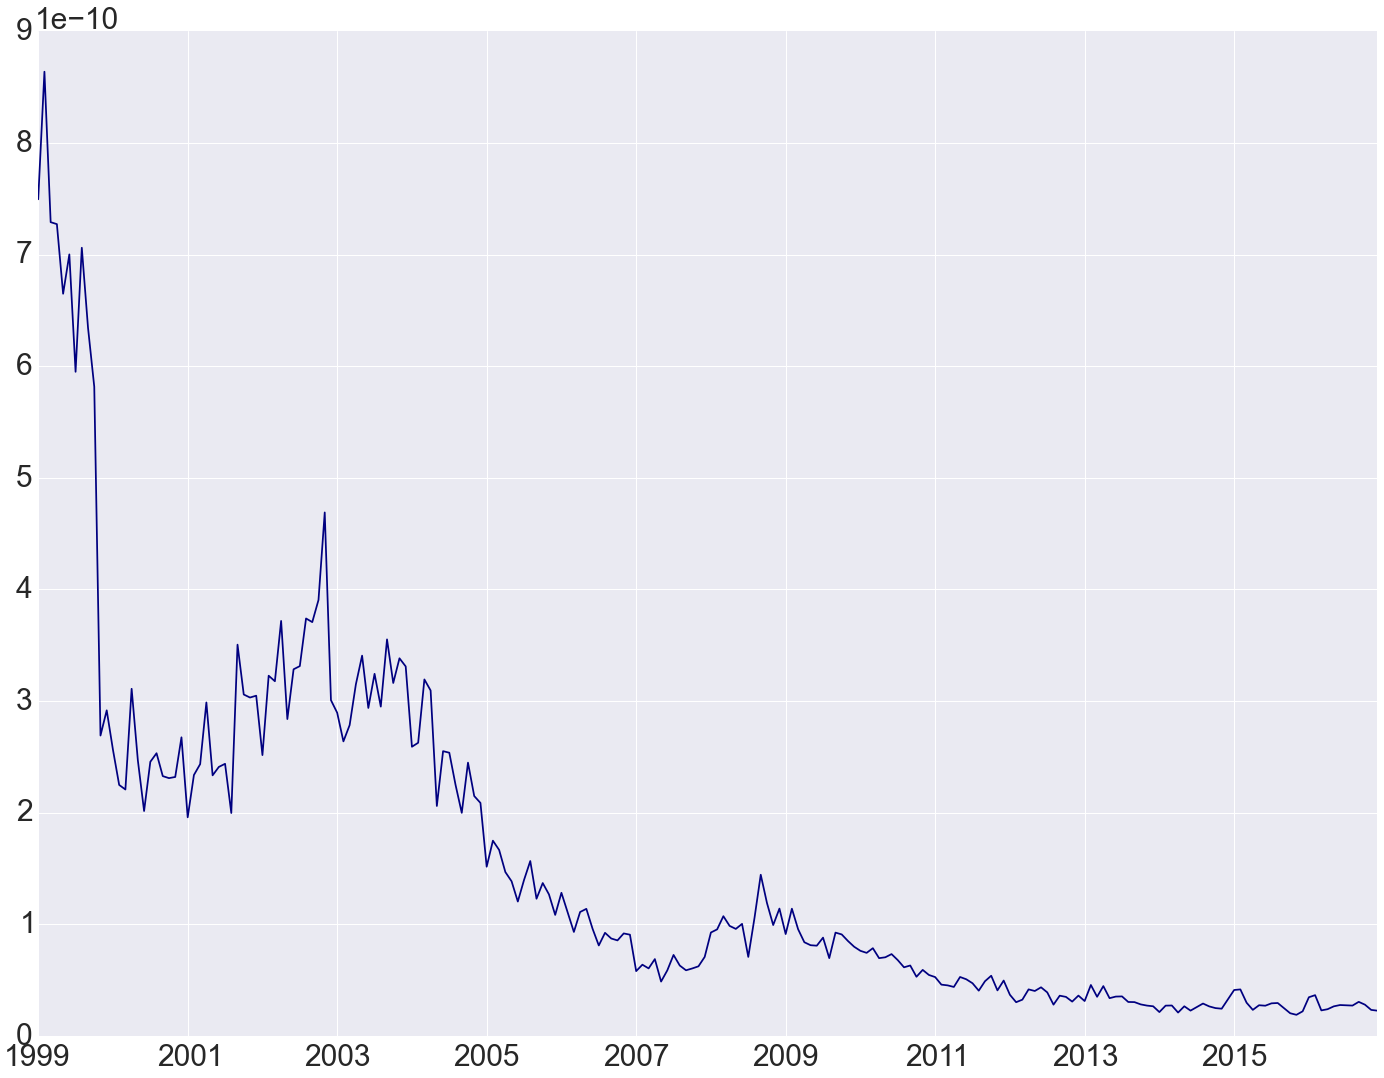

In [69]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 
amihud.median(axis=1).dropna().plot(colormap='jet')

# Bank of International Settlement 
 * Turnover and Open Interest in exchange traded futures
 * Global data on all futures contracts
 * Problem this data only goes to 2012
 * Quarterly data

In [144]:
futures=pd.DataFrame()
futures['OI']=quandl.get('BIS/EXCHDERIV_0',authtoken=token)['USD Billions']
futures['Turnover']=quandl.get('BIS/EXCHDERIV_32',authtoken=token)['USD Billions']

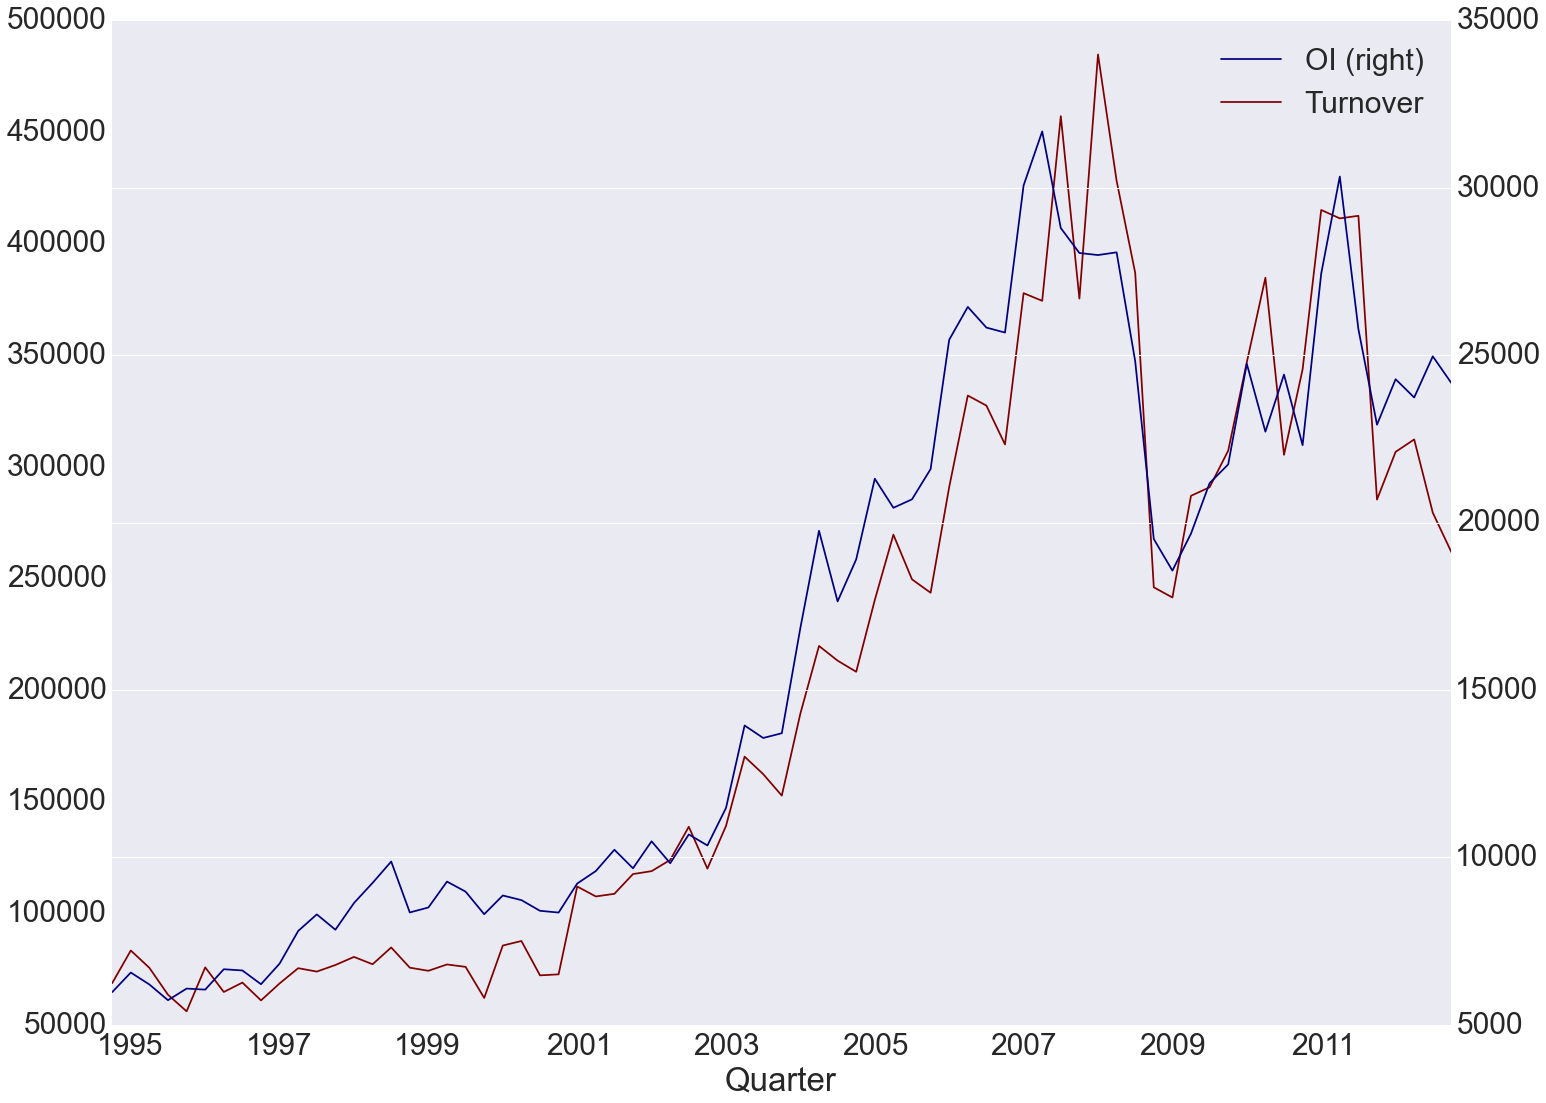

In [295]:
futures.plot(secondary_y='OI',colormap='jet')

In [270]:
mkt_liquidity=amihud.median(axis=1).dropna()
total_AUM=etf[etf_list].sum(axis=1).resample(rule='m')
ind=futures.index
ex=pd.DataFrame()
ex['Amihud']=mkt_liquidity[ind]
ex['OI']=futures.OI
ex['Turnover']=futures.Turnover
ex['Intercept']=1
ex=ex.dropna()
res1=sm.OLS(ex.Amihud,ex[['Intercept','OI']]).fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     80.80
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           2.59e-12
Time:                        07:24:38   Log-Likelihood:                 1209.9
No. Observations:                  56   AIC:                            -2416.
Df Residuals:                      54   BIC:                            -2412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.056e-10   3.79e-11     13.356      0.0

In [271]:
res2=sm.OLS(ex.Amihud,ex[['Intercept','Turnover']]).fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     72.91
Date:                Mon, 17 Jul 2017   Prob (F-statistic):           1.34e-11
Time:                        07:24:40   Log-Likelihood:                 1208.3
No. Observations:                  56   AIC:                            -2413.
Df Residuals:                      54   BIC:                            -2408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.359e-10   3.22e-11     13.524      0.0

In [276]:
tab=pd.DataFrame()
for c in ['OI','Turnover']:
    res=sm.OLS(ex.Amihud,ex[['Intercept',c]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept*1e10
    s['Intercept T']=res.tvalues.Intercept
    s['Arg']=res.params[c]*1e10
    s['T']=res.tvalues[c]
    s['R^2']=res.rsquared_adj
    tab[c]=s   

In [277]:
tab

,OI,Turnover
Intercept,5.056066,4.358543
Intercept T,13.356301,13.523695
Arg,-0.000168,-0.000010
T,-8.988619,-8.538831
R^2,0.591974,0.566628


In [279]:
print tab.to_latex()

\begin{tabular}{lrr}
\toprule
{} &         OI &   Turnover \\
\midrule
Intercept   &   5.056066 &   4.358543 \\
Intercept T &  13.356301 &  13.523695 \\
Arg         &  -0.000168 &  -0.000010 \\
T           &  -8.988619 &  -8.538831 \\
R\textasciicircum2         &   0.591974 &   0.566628 \\
\bottomrule
\end{tabular}



# Largest ETF data for Commodity 
 * Source: CRSP
 * Using the largest ETN funds that trade commodity futures to determine the rough size of the industry and see if the AUM in these ETF drive the liquidity in the market
 * Somthing is wrong with OIL and DJP

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


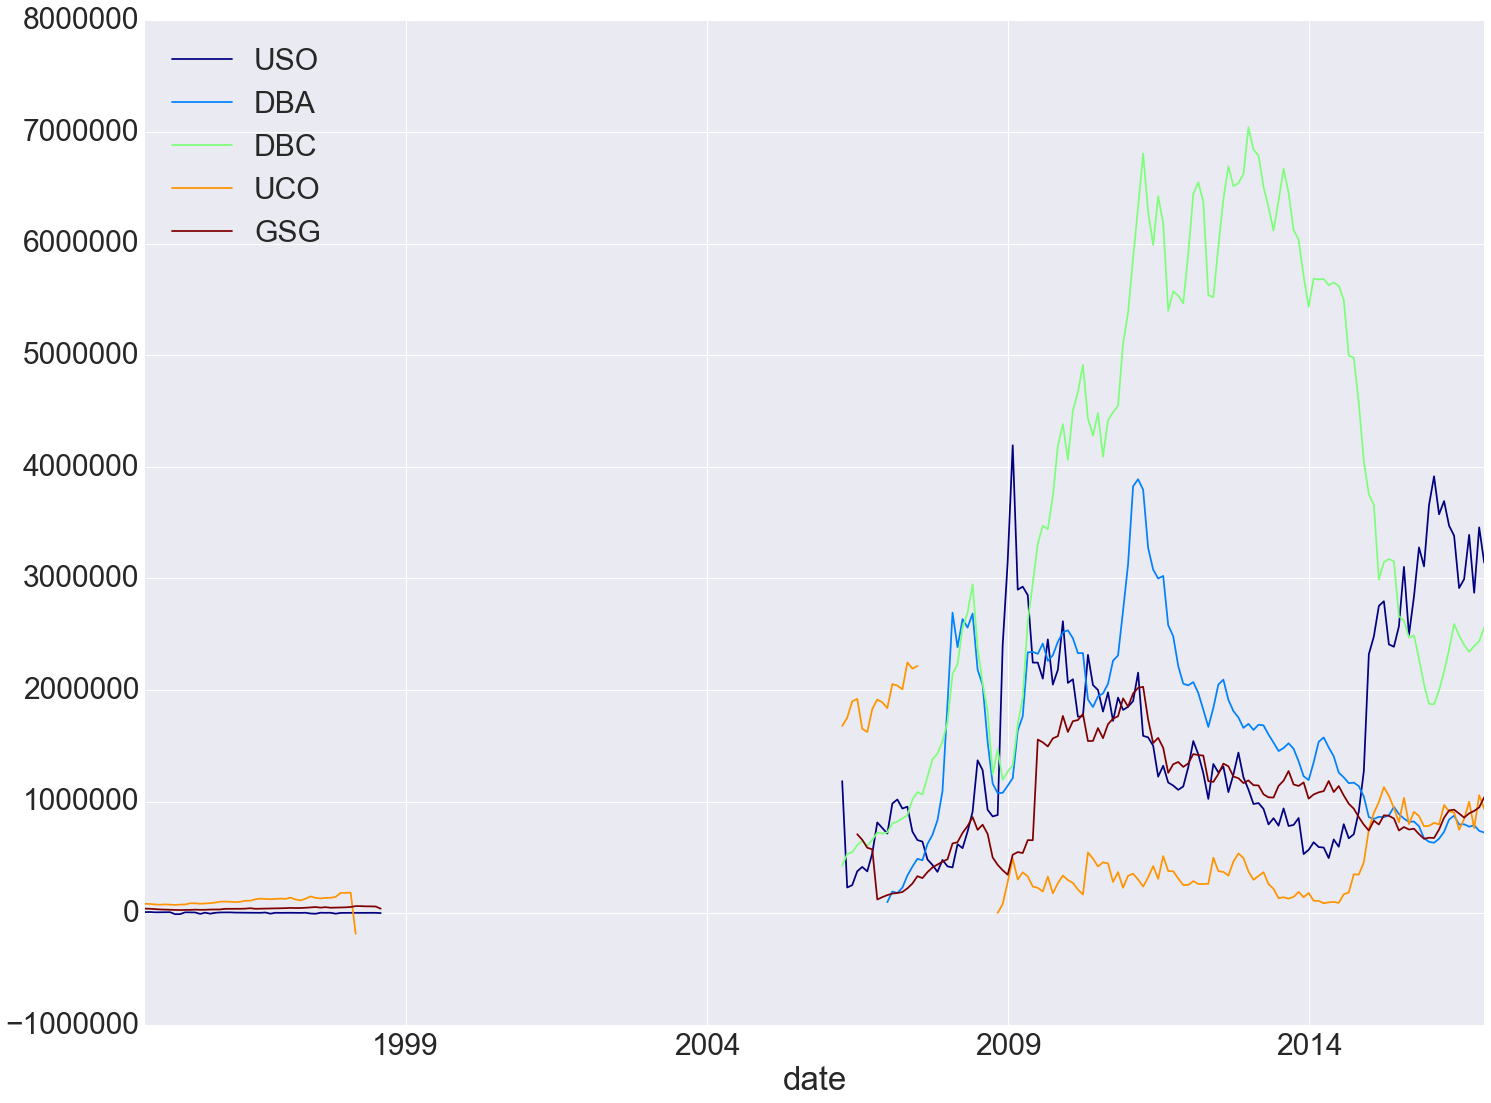

In [338]:
data=pd.read_csv('ETF_Price.csv',parse_dates=['date'])
etf_list=['USO','DBA','DBC','UCO','GSG']
etf=pd.DataFrame()
for e in etf_list:
    x=data[data.TICKER==e].set_index('date')
    etf[e]=x.PRC * x.SHROUT
etf.resample(rule='m').plot(colormap='jet')

In [339]:
mkt_liquidity=amihud.median(axis=1).dropna()
total_AUM=etf[etf_list].sum(axis=1).resample(rule='m')
ind=total_AUM[:'2016'].index
ex=pd.DataFrame()
ex['Amihud']=mkt_liquidity[ind]
ex['ETF AUM']=total_AUM[:'2016']
ex['Intercept']=1
res=sm.OLS(ex.Amihud,ex[['Intercept','ETF AUM']]).fit()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


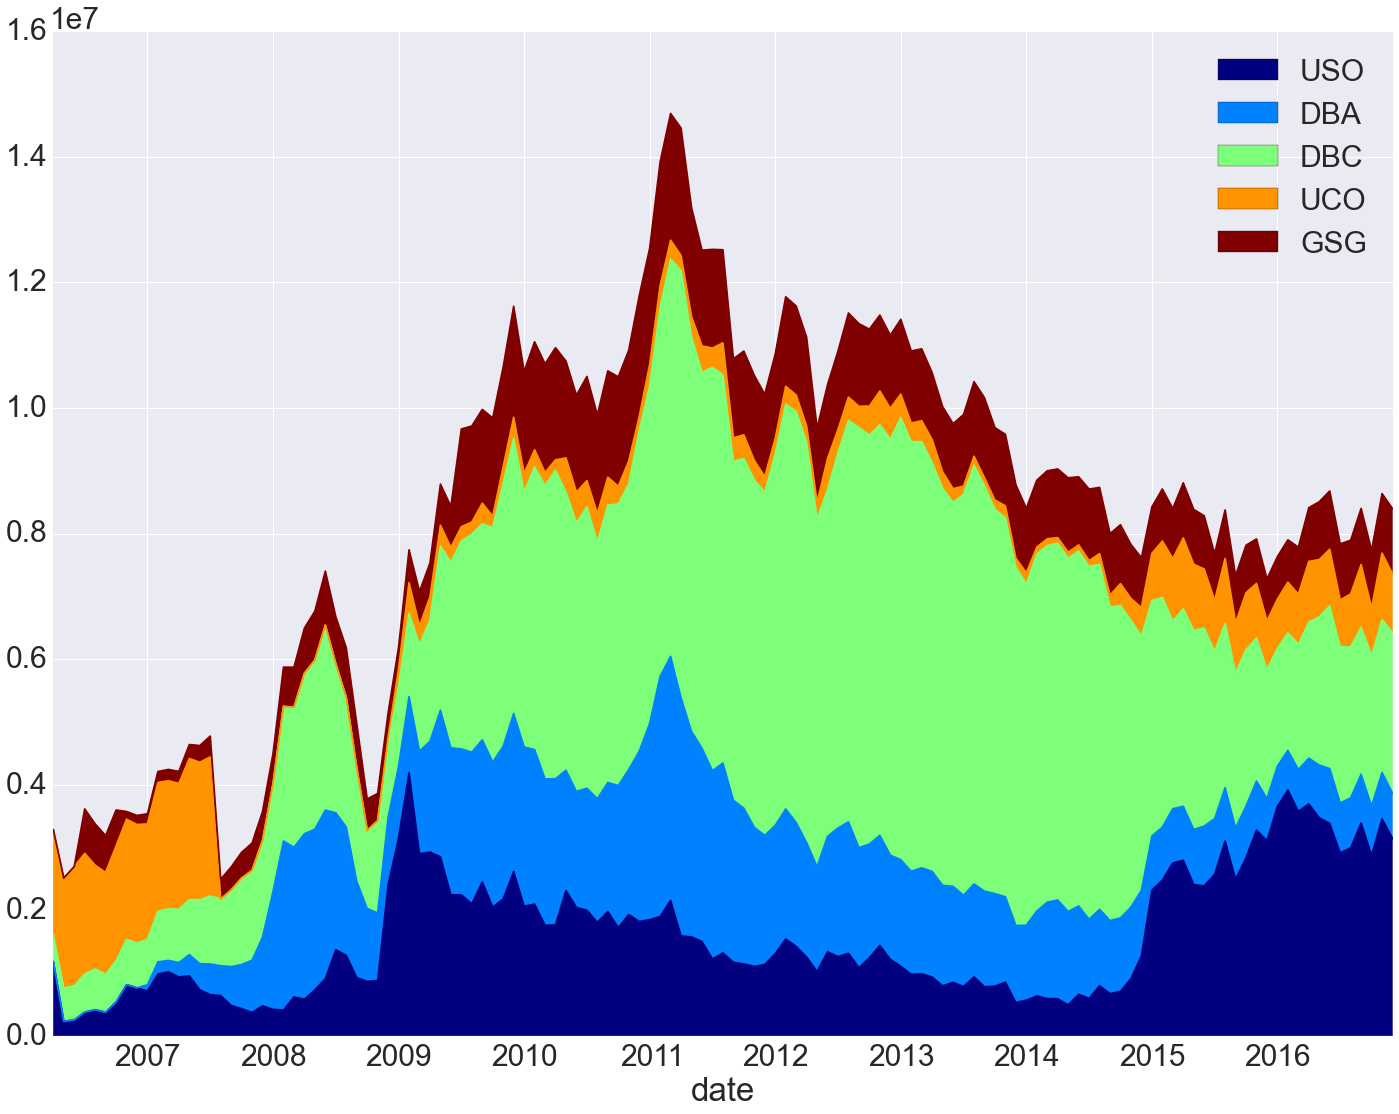

In [347]:
etf['2000':].dropna(how='all').resample(rule='m').plot(colormap='jet',kind='area',stacked=True)

In [297]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     12.96
Date:                Tue, 18 Jul 2017   Prob (F-statistic):           0.000466
Time:                        20:15:00   Log-Likelihood:                 2755.3
No. Observations:                 120   AIC:                            -5507.
Df Residuals:                     118   BIC:                            -5501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.775e-11   7.59e-12     10.242      0.0

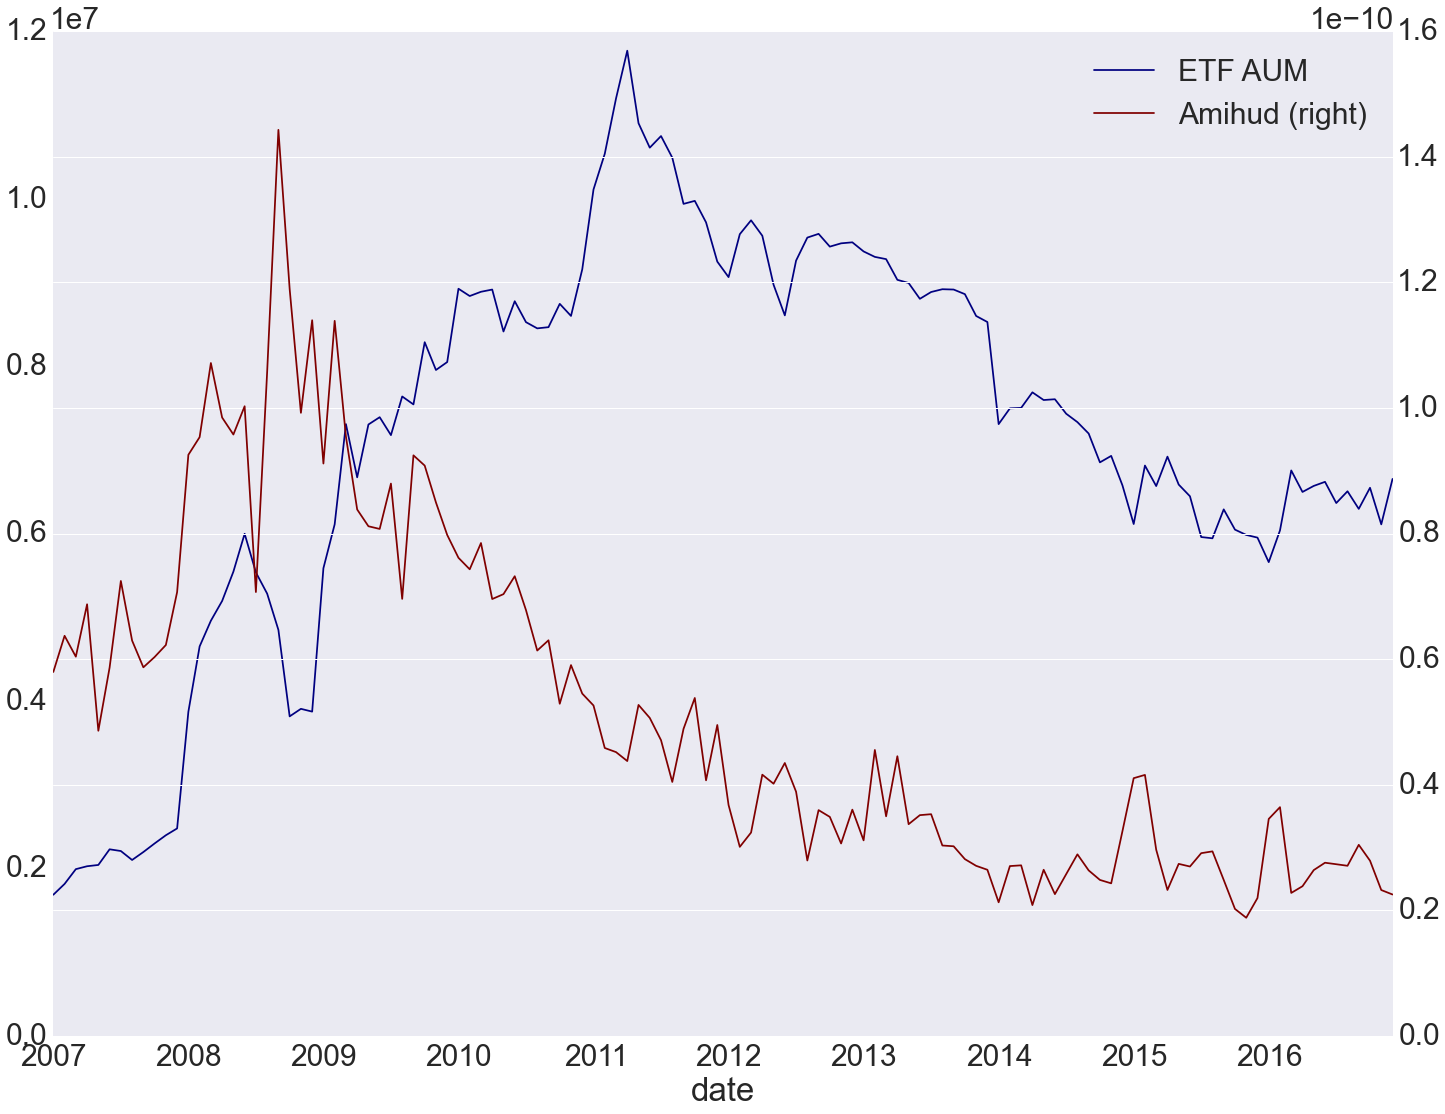

In [149]:
ex[['ETF AUM','Amihud']].plot(secondary_y='Amihud',colormap='jet')

#Hedge Fund Index
    Credit Suisse Alt Beta indices

In [367]:
cs_data=pd.read_csv('CS_AltBeta.csv',parse_dates=['Date'],index_col=[0])

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


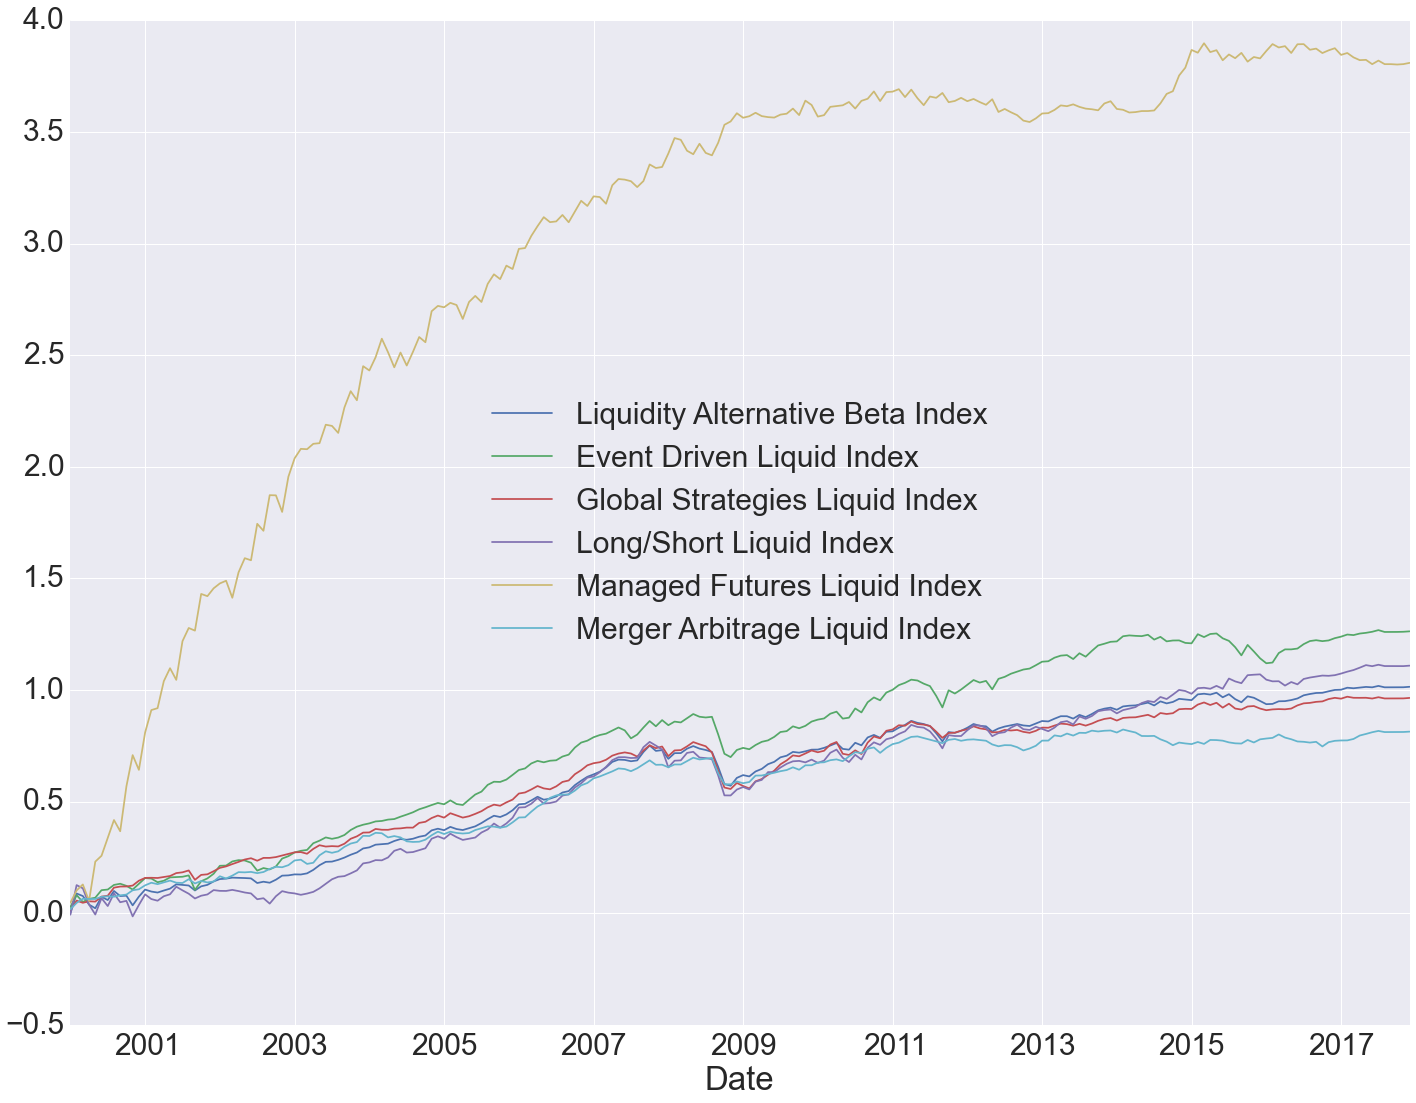

In [426]:
cs_data['2000':].dropna().cumsum().resample(rule='m',how='last').plot()

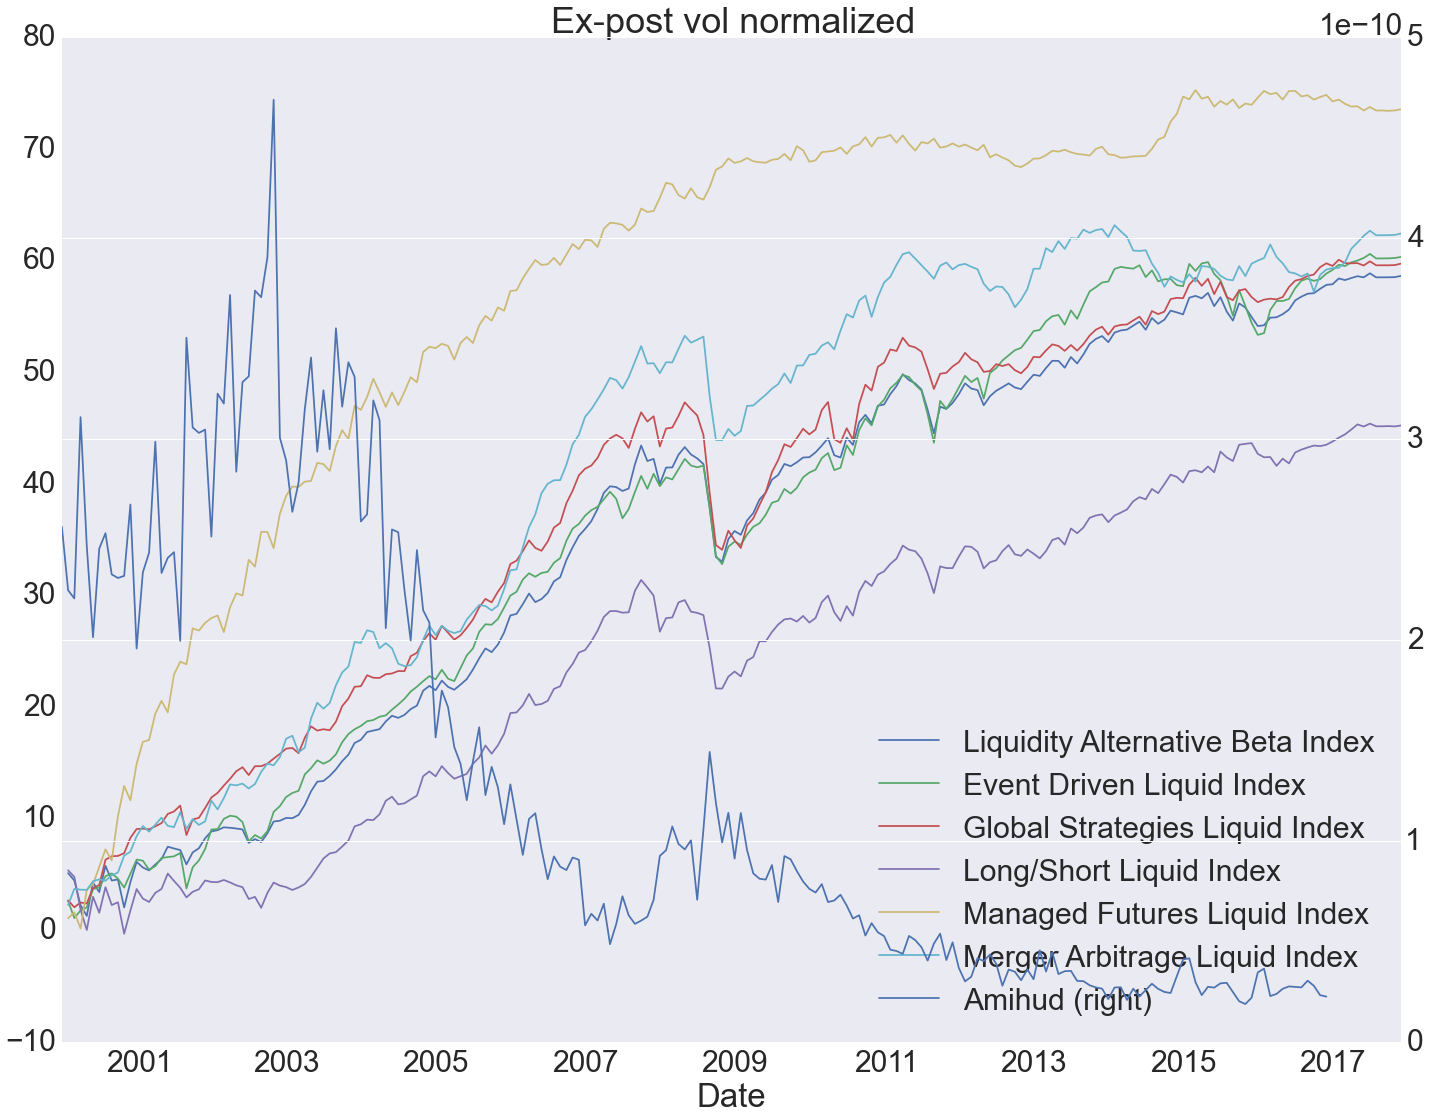

In [459]:
x=(cs_month.diff()/cs_month.diff().std()).cumsum()
x['Amihud']=amihud.median(axis=1).dropna()
x.plot(title='Ex-post vol normalized',secondary_y='Amihud')

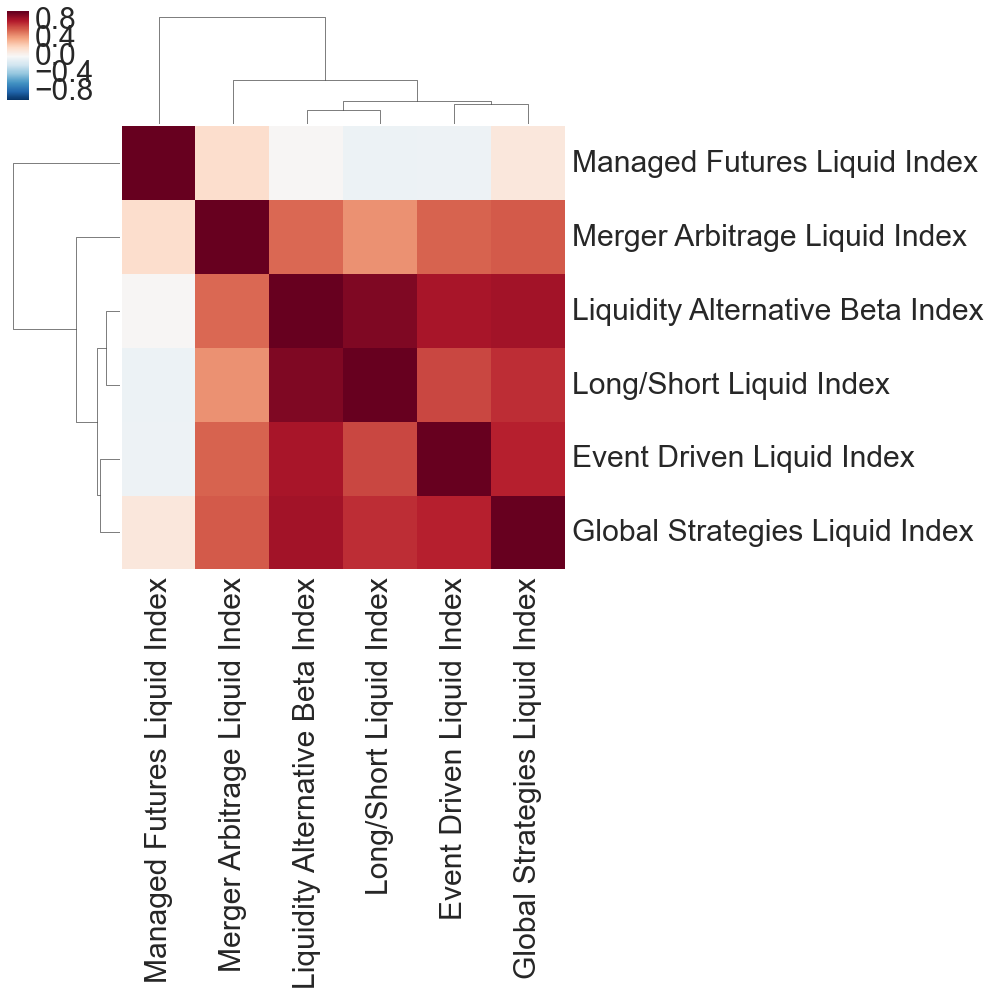

In [454]:
sns.clustermap(cs_month.diff().corr())

In [422]:
cs_month=cs_data.dropna().cumsum().resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [462]:
mkt_liquidity=amihud.median(axis=1).dropna()
ind_res2 = pd.DataFrame()
for c in cs_month.columns:
    s=pd.Series()
    ind=cs_month[c].dropna()['2000':'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(cs_month[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud (x1e-9)']=res.params.Amihud/1e9
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res2[c]=s

In [463]:
ind_res2.round(2)

,Liquidity Alternative Beta Index,Event Driven Liquid Index,Global Strategies Liquid Index,Long/Short Liquid Index,Managed Futures Liquid Index,Merger Arbitrage Liquid Index
Intercept,0.92,1.15,0.89,0.94,3.92,0.81
Intercept Tstat,70.26,68.00,71.94,66.95,62.83,71.13
Amihud (x1e-9),-2.61,-3.16,-2.27,-2.86,-7.68,-2.08
Amihud Tstat,-33.21,-31.27,-30.63,-34.18,-20.63,-30.76
Adj R^2,0.84,0.83,0.82,0.85,0.68,0.82


In [448]:
print ind_res2.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Liquidity Alternative Beta Index &  Event Driven Liquid Index &  Global Strategies Liquid Index &  Long/Short Liquid Index &  Managed Futures Liquid Index &  Merger Arbitrage Liquid Index \\
\midrule
Intercept       &                              0.92 &                       1.15 &                            0.89 &                     0.94 &                          3.92 &                           0.81 \\
Intercept Tstat &                             70.26 &                      68.00 &                           71.94 &                    66.95 &                         62.83 &                          71.13 \\
Amihud (x1e-9)  &                             -2.61 &                      -3.16 &                           -2.27 &                    -2.86 &                         -7.68 &                          -2.08 \\
Amihud Tstat    &                            -33.21 &                     -31.27 &                          -30.63 &              

#Hedge Fund Index
* Can Amihud explain HF performance.  For example does increased liquidity reduce the amount of returns in hedge funds


In [285]:
mkt={
    'Eurekahedge Multi–Factor Risk Premia Index':'EUREKA/MEI27',
    'Eurekahedge CTA/Managed Futures Hedge Fund Index':'EUREKA/476',
    'Eurekahedge Macro Hedge Fund Index':'EUREKA/481',
    'Eurekahedge Trend Following Index':'EUREKA/647',
    'Eurekahedge Commodity Hedge Fund Index':'EUREKA/650'
}
index=pd.DataFrame()
for k,tick in mkt.items():
    index[k]=quandl.get(tick,authtoken=token).Returns

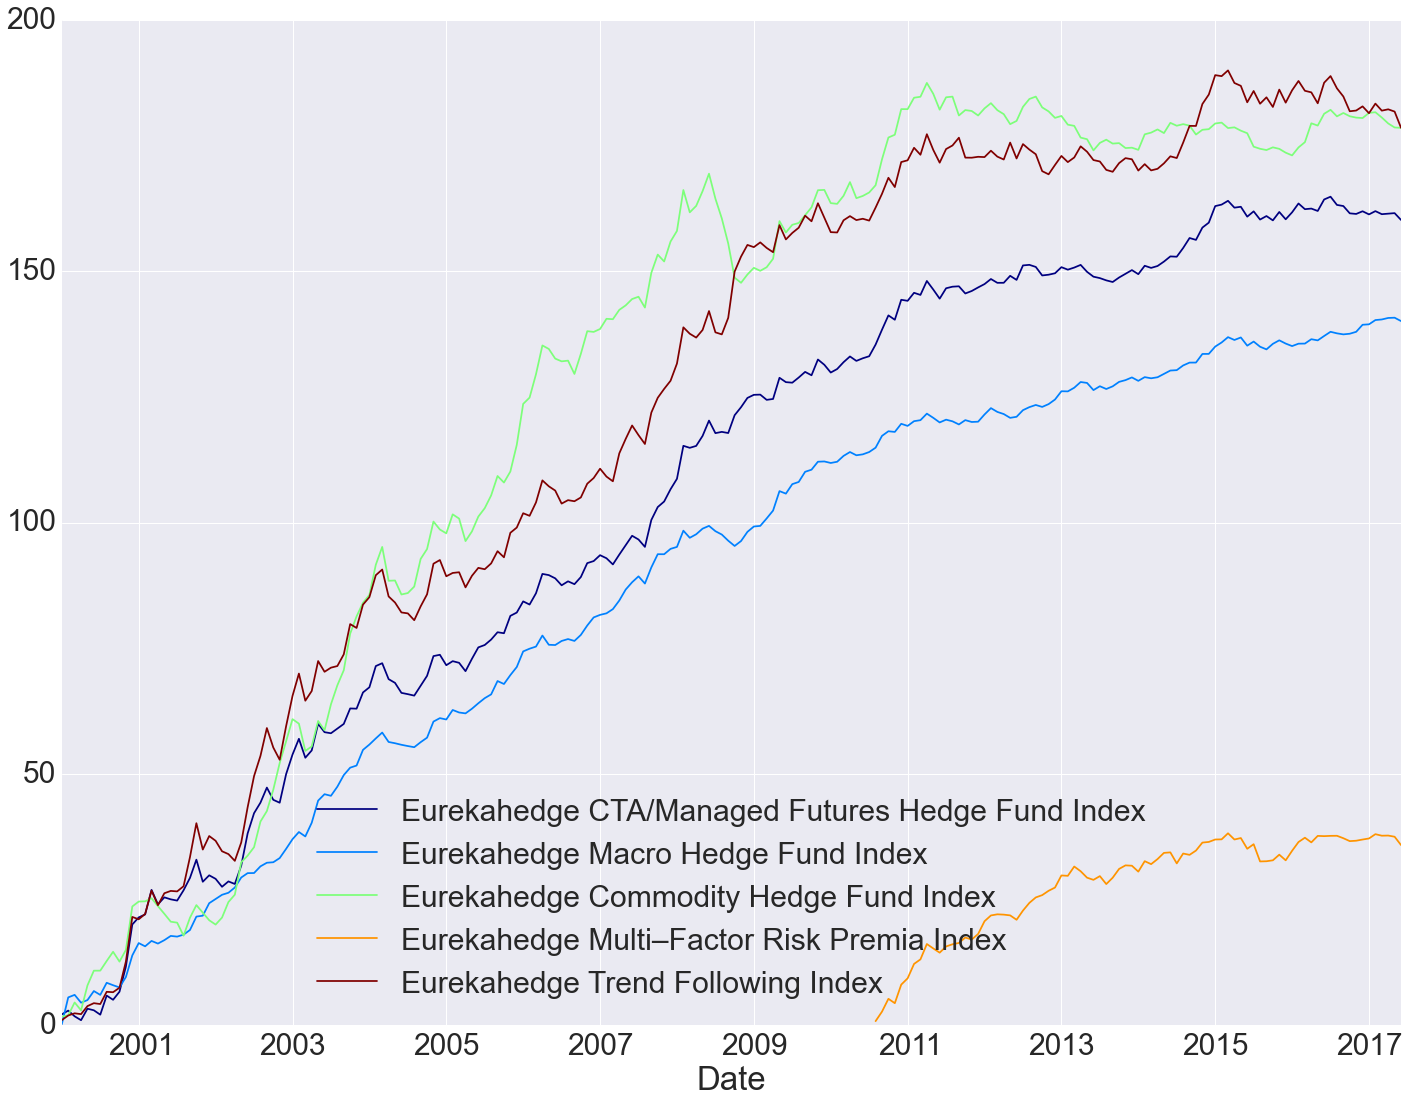

In [287]:
index.cumsum().plot(colormap='jet')

In [288]:
mkt_liquidity=amihud.median(axis=1).dropna()
ind_res = pd.DataFrame()
for c in index.columns:
    s=pd.Series()
    ind=index[c].dropna()[:'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(index[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud']=res.params.Amihud
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res[c]=s

In [293]:
ind_res

,Eurekahedge CTA/Managed Futures Hedge Fund Index,Eurekahedge Macro Hedge Fund Index,Eurekahedge Commodity Hedge Fund Index,Eurekahedge Multi–Factor Risk Premia Index,Eurekahedge Trend Following Index
Intercept,4.399603e-01,4.023687e-01,1.240348e-01,-4.550051e-01,3.444947e-01
Intercept Tstat,2.117453e+00,3.259247e+00,4.365651e-01,-9.406361e-01,1.178657e+00
Amihud,2.781537e+09,2.206684e+09,5.977675e+09,2.698570e+10,4.335552e+09
Amihud Tstat,2.239856e+00,2.990668e+00,3.520243e+00,2.021497e+00,2.481900e+00
Adj R^2,1.940400e-02,3.765971e-02,5.313679e-02,3.902628e-02,2.478781e-02


In [294]:
print ind_res.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Eurekahedge CTA/Managed Futures Hedge Fund Index &  Eurekahedge Macro Hedge Fund Index &  Eurekahedge Commodity Hedge Fund Index &  Eurekahedge Multi–Factor Risk Premia Index &  Eurekahedge Trend Following Index \\
\midrule
Intercept       &                                      4.399603e-01 &                        4.023687e-01 &                            1.240348e-01 &                               -4.550051e-01 &                       3.444947e-01 \\
Intercept Tstat &                                      2.117453e+00 &                        3.259247e+00 &                            4.365651e-01 &                               -9.406361e-01 &                       1.178657e+00 \\
Amihud          &                                      2.781537e+09 &                        2.206684e+09 &                            5.977675e+09 &                                2.698570e+10 &                       4.335552e+09 \\
Amihud Tstat    &                  

#Hedge Fund AUM
* Does increase in Hedge Fund AUM describe the rise of liquidity

Problems:
* We don't have great proxies for HFT shops

# US 40 Act funds using CRSP Mutual Fund Database
* Can we use AUM of the funds to describe the increase in market liquidity
* Amihud and performance?  However, how far back does the 40 ACt fund goes

In [170]:
MF_data=pd.read_csv('MutualFund.csv',parse_dates=['caldt'])

In [171]:
MF_data.columns

Index([u'summary_period2', u'crsp_fundno', u'caldt', u'nav_latest',
       u'nav_latest_dt', u'tna_latest', u'tna_latest_dt', u'yield', u'div_ytd',
       u'cap_gains_ytd', u'unrealized_app_dep', u'unrealized_app_dt',
       u'per_com', u'per_pref', u'per_conv', u'per_corp', u'per_muni',
       u'per_govt', u'per_oth', u'per_cash', u'per_bond', u'per_abs',
       u'per_mbs', u'maturity', u'crsp_cl_grp', u'fund_name', u'nasdaq',
       u'mgmt_name', u'mgr_name', u'inst_fund', u'index_fund_flag', u'et_flag',
       u'exp_ratio', u'mgmt_fee', u'turn_ratio', u'fiscal_yearend', u'policy',
       u'lipper_class', u'lipper_class_name', u'lipper_asset_cd'],
      dtype='object')

In [300]:
MF_data[MF_data.nasdaq=='AQMIX'].T

,473684,473685,473686,473687,473688,473689,473690
summary_period2,AQ,AQ,AQ,AQ,AQ,AQ,AQ
crsp_fundno,48695,48695,48695,48695,48695,48695,48695
caldt,2010-12-31 00:00:00,2011-12-30 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-30 00:00:00
nav_latest,10.3,9.57,9.78,10.59,10.63,10.18,9.32
nav_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
tna_latest,655.4,1081.1,2129.7,4497.2,5620.1,7777.1,7666
tna_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
yield,0.00850485,0.00401254,0.00764417,NaN,0.0449247,0.0448625,0.000175215
div_ytd,0.0876,0.0384,0.07476,NaN,0.47755,0.4567,0.001633
cap_gains_ytd,0.1496,0.0363,NaN,0.10739,0.49011,0.20628,NaN


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


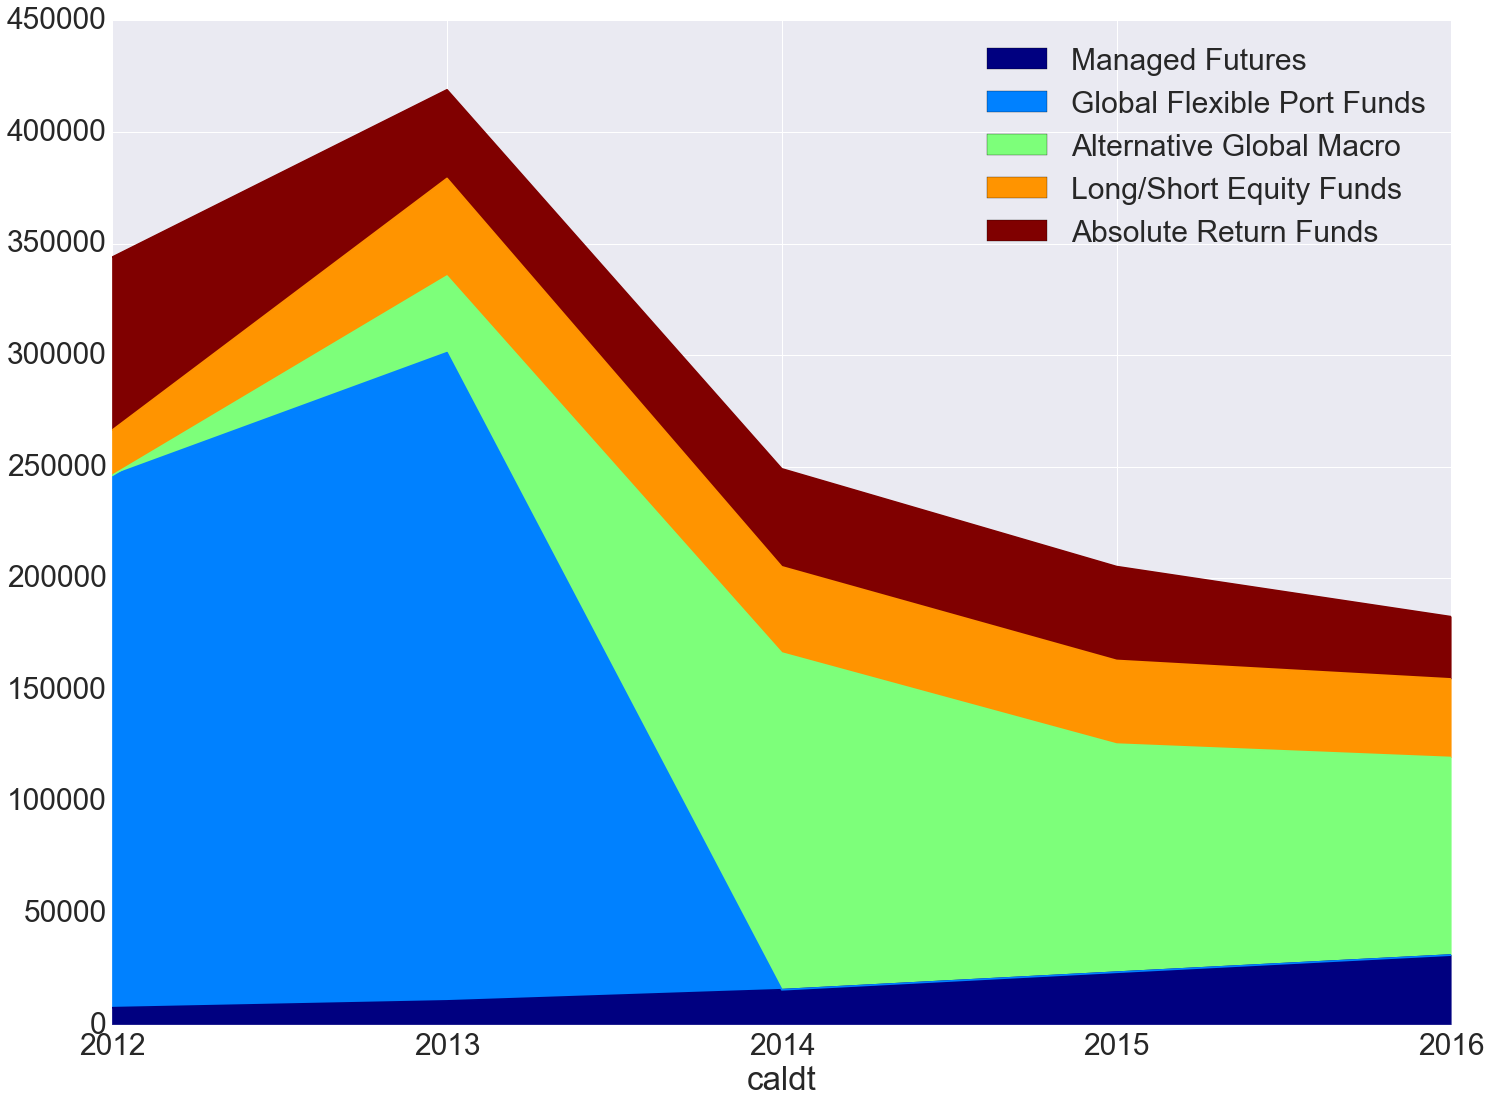

In [240]:
types={'Long/Short Equity Funds':'LSE',
       'Managed Futures':'MFF',
       'Absolute Return Funds':'ABR',
       'Alternative Global Macro':'AGM',
       'Global Flexible Port Funds':'GX'}
asset_alt=pd.DataFrame()
for k,tick in types.items():
    asset_alt[k]=MF_data[MF_data.lipper_class==tick].set_index('caldt').tna_latest.dropna(how='all').astype('float').resample(rule='m',how='sum').dropna()
asset_alt.plot(kind='area',colormap='jet',stacked=True)

In [307]:
x=MF_data[MF_data.lipper_class=='MFF']
no=x.crsp_fundno.unique()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


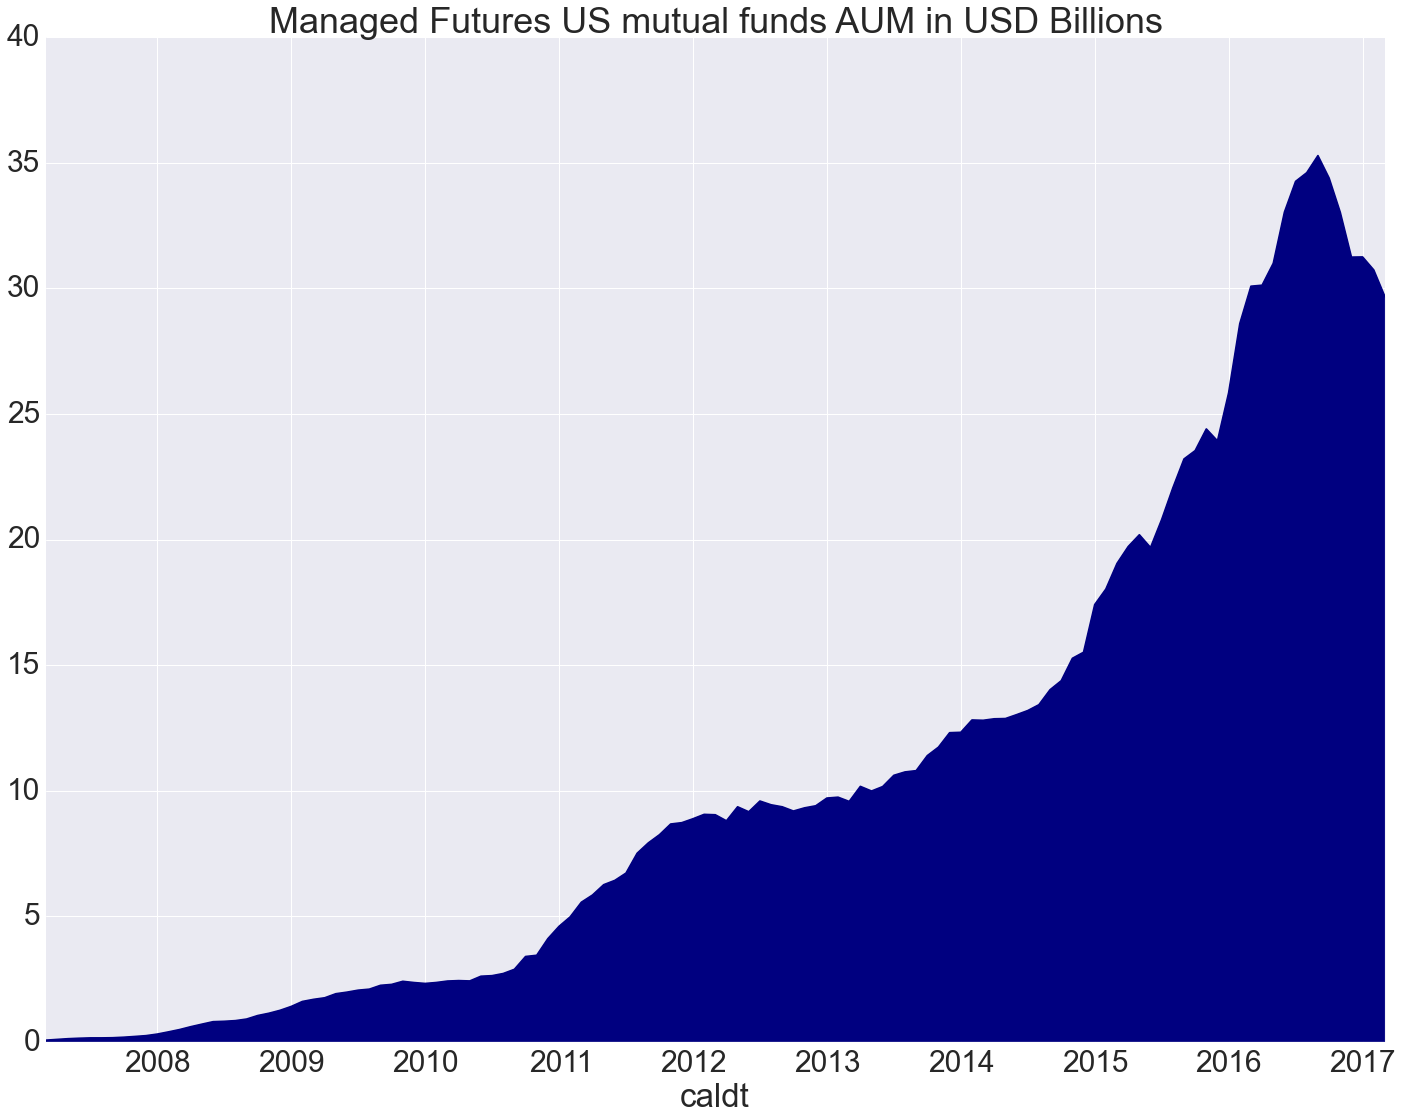

In [333]:
x=pd.read_csv('MF_Funds.csv',parse_dates=['caldt']).set_index('caldt').mtna.resample(rule='m',how='sum')
(x/1000).plot(kind='area',colormap='jet',title='Managed Futures US mutual funds AUM in USD Billions')